<center><h2><b>Imports</b></h2></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from konlpy.tag import Kkma
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# KKMA

In [2]:
kkma = Kkma()

In [3]:
#영화리뷰 데이터 읽어오기
df = pd.read_csv("./data/processed/base_df.csv", encoding='utf-8')

#불용어 읽어오기
stopwords = pd.read_csv("./data/stopwords.txt")
stopwords = stopwords['word'].tolist()

<center><h2><b>Data Preprocessing</b></h2></center>

In [4]:
# Tokenized 
tk = []
for sentence in tqdm(df['review']) :
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tk.append(stopwords_removed_sentence)

100%|██████████| 9304/9304 [03:28<00:00, 44.57it/s]


In [5]:
tk[:3]

[['판타지',
  '넘',
  '영화',
  '역사',
  '남',
  '명작',
  '다',
  '내',
  '극장',
  '못',
  '보',
  '았',
  '을까',
  '폰',
  '보',
  '았',
  '감동',
  '비',
  '교가',
  '안',
  '되',
  'ㄹ',
  '터',
  'ㄴ데'],
 ['이집트', '여행', '느낌', '영화'],
 ['목포', '연설', '장면', '넋', '잃', '고', '보', '게', '되', 'ㄴ다']]

In [6]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tk)

In [8]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11981
등장 빈도가 2번 이하인 희귀 단어의 수: 7322
단어 집합에서 희귀 단어의 비율: 61.1134295968617
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.9816833746462805


4.7% 수준인 희귀빈도를 배제하고 진행

In [9]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4660


In [10]:
#텍스트 시퀀스 >> 정수 시퀀스
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(tk)
tk = tokenizer.texts_to_sequences(tk)
print(tk[:3])

[[611, 173, 3, 653, 77, 182, 6, 71, 297, 146, 4, 9, 236, 3141, 4, 9, 67, 265, 40, 14, 7, 315, 59], [3142, 1174, 56, 3], [2183, 82, 904, 2, 4, 10, 14, 35]]


In [11]:
#target data 따로 지정
yy = np.array(df['sentiment'])

In [12]:
# 빈 샘플 제거
drop_index = [index for index, sentence in enumerate(tk) if len(sentence) < 1]
len(drop_index)

5

In [13]:
tk = np.delete(tk, drop_index, axis=0)
yy = np.delete(yy, drop_index, axis=0)
print(len(tk))
print(len(yy))

9299
9299


C:\Users\kdh\miniconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 349
리뷰의 평균 길이 : 18.63254113345521


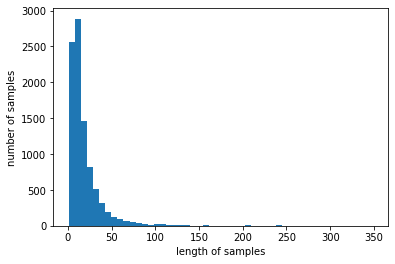

In [14]:
#패딩
print('리뷰의 최대 길이 :',max(len(review) for review in tk))
print('리뷰의 평균 길이 :',sum(map(len, tk))/len(tk))
plt.hist([len(review) for review in tk], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

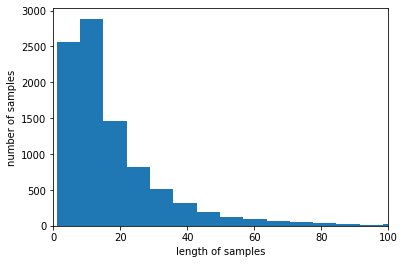

In [15]:
plt.hist([len(review) for review in tk], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.xlim(0, 100)
plt.show()

max_len이 50 정도면 될것 같음

In [16]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 50
below_threshold_len(max_len, tk)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.36498548230993


In [17]:
final = pad_sequences(tk, maxlen=max_len)

In [18]:
final_ = list(map(lambda x:[x],final.astype(object)))

In [19]:
final_df = pd.DataFrame(final_,columns=['word'])

y_df = pd.DataFrame(yy)

In [20]:
final_df.head()

,word
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


final_df

In [21]:
final_df = pd.concat([final_df, y_df], axis=1)
final_df.columns = ['word','label']

In [22]:
final_df.to_csv('./data/processed/kkma_df.csv')